In [1]:
import pandas as pd
df=pd.read_csv('learning_sessions.csv', index_col=0)
# df.info()

## Data observation

In [ ]:
priors = df.groupby('learning_activity', as_index=True).agg({'uuid':'nunique',
                                                              'subscription_started_at':'count'})
priors.columns = ['n_users', 'n_sessions']

priors

In [ ]:
relative_priors = ((df.groupby('learning_activity', as_index=True).agg({'uuid':'nunique',
                                                              'subscription_started_at':'count'})/\
                                df.agg({'uuid':'nunique','subscription_started_at':'count'}))*100).round(1)
                                                        
relative_priors.columns = ['percent_users', 'percent_sessions']

relative_priors

In [ ]:
# ll = []

# for i in ['age', 'motivation', 'subscription_type', 'subscription_geo_area',
#             'learning_os', 'learning_language', 'session_ended_as']:

#         tt = df.groupby(['learning_activity', i], as_index=True).agg({'uuid':'nunique',
#                                                               'subscription_started_at':'count'})
                                                              
#         tt.columns = ['n_users', 'n_sessions']

#         ll.append(tt)

# ll[0]

In [ ]:
# let's observe the combinations of learnign activities (the order matters)
# cronology matters!
combis = df.sort_values(by='subscription_started_at').\
            groupby('uuid', as_index=False).agg({'learning_activity':lambda x: ','.join(x.unique())})

combis = combis.groupby('learning_activity', as_index=False).uuid.nunique()

combis.sort_values(by='uuid', ascending=False)

## let's observe the relationship between the learning types

In [84]:
# for the sankey we take only the users that have their entire set of events from the very registration 
df1=df.groupby('uuid').filter(lambda x: pd.to_datetime(x.session_started_at).min() 
                                    >= pd.to_datetime(x.subscription_started_at).min())

# df1['combination']=df1['learning_activity']+'_'+df1['learning_language'].fillna('no_lang_info')

df1['combination']=df1['learning_activity']
df1=df1[['uuid','session_started_at','combination']]

# transform to date
df1.session_started_at = pd.to_datetime(df1.session_started_at)

In [85]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293913 entries, 0 to 6378
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   uuid                293913 non-null  object        
 1   session_started_at  293913 non-null  datetime64[ns]
 2   combination         293913 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 9.0+ MB


In [86]:
# let's also have a "starting point" in the sankey diagram
# we will call "registered" 
# we assume the registration to occure 1 year before first event
regi = df1.groupby('uuid',as_index=False).session_started_at.min()
regi['session_started_at'] = regi['session_started_at']\
                 - pd.to_timedelta(365, unit='d')
regi['combination'] = 'registered'

In [87]:
regi.head()

,uuid,session_started_at,combination
0,00170ba6529ac49588e6fb398b6a2663,2020-11-08 13:49:15.847,registered
1,001776e5719732fb84aaa50c18e1e293,2020-10-07 14:07:50.279,registered
2,002302143a907de120aecf48a3b36fad,2020-09-01 11:46:56.770,registered
3,002e19a51de17d56c4bf1d4678ca54f1,2020-10-03 17:46:28.000,registered
4,003230018eadf5efa0275bf8efecdb12,2020-11-12 02:35:39.298,registered


In [88]:
# add to original df the new registration event
df1 = pd.concat([df1,regi],axis=0)

In [89]:
# order by session start ascending
df1 = df1.sort_values(by=['uuid','session_started_at'], ascending=True)

In [90]:
# lead the combination of lesson and learning type to have the conversion pairs
df1['forward'] = df1.groupby(['uuid'])['combination'].shift(-1)
df1.head()

,uuid,session_started_at,combination,forward
0,00170ba6529ac49588e6fb398b6a2663,2020-11-08 13:49:15.847,registered,lesson
4579,00170ba6529ac49588e6fb398b6a2663,2021-11-08 13:49:15.847,lesson,lesson
6312,00170ba6529ac49588e6fb398b6a2663,2021-11-08 13:54:46.090,lesson,lesson
7718,00170ba6529ac49588e6fb398b6a2663,2021-11-08 14:36:07.256,lesson,lesson
15849,00170ba6529ac49588e6fb398b6a2663,2021-11-10 13:34:54.945,lesson,lesson


In [91]:
# remove the duplicate pairs leaving only "interesting" transitions
df1=df1[df1.combination!=df1.forward].dropna()

In [92]:
# aggregate the combinations
hello = df1.groupby(['combination','forward'], as_index=False).uuid.nunique()\
            .sort_values(by='uuid', ascending=False)

In [93]:
# calcualte transmissions percentage
hello['percent_of_total']=(hello.uuid/df1.uuid.nunique()*100).round(1)

In [94]:
labels = hello.combination.unique().tolist()
labels

['lesson', 'review', 'registered', 'game', 'audio', 'live']

In [95]:
# for sankey plot
hello['start_index']=hello.combination.apply(lambda x: labels.index(x))
hello['end_index']=hello.forward.apply(lambda x: labels.index(x))
hello.head()

,combination,forward,uuid,percent_of_total,start_index,end_index
11,lesson,review,7277,78.4,0,1
23,review,lesson,7126,76.7,1,0
18,registered,lesson,6727,72.5,2,0
20,registered,review,2463,26.5,2,1
22,review,game,1155,12.4,1,3


In [96]:
# sankey

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = hello.start_index.values.tolist(), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = hello.end_index.values.tolist(),
      value = hello.percent_of_total.values.tolist()
  ))])

fig.update_layout(title_text="Transitions within the learning mode types in % of total number of users", font_size=10)
fig.show()

## More appropriate sankey with ordering of the events

In [97]:
# Let's have sankey with cronology of the events
df1['rank_event']=df1.groupby('uuid',as_index=False).session_started_at.rank("dense", ascending=True)\
            .session_started_at.apply(int)

# in sankey we will include the order parameter in labels 
df1.combination=df1.combination + '_' + df1.rank_event.apply(str)
df1.forward=df1.forward + '_' + (df1.rank_event+1).apply(str)

In [98]:
# aggregate the combinations - let's limit ourselves with top 7 levels
hello = df1[df1.rank_event<=6].groupby(['combination','forward'], as_index=False).uuid.nunique()\
            .sort_values(by='uuid', ascending=False)

In [99]:
# calcualte transmissions percentage
hello['percent_of_total']=(hello.uuid/df1.uuid.nunique()*100).round(1)

In [100]:
labels = list(set(hello[['combination','forward']].values.reshape(-1)))
labels

['live_3',
 'registered_1',
 'game_7',
 'game_3',
 'game_5',
 'lesson_7',
 'audio_5',
 'lesson_6',
 'live_7',
 'live_4',
 'audio_7',
 'live_2',
 'audio_3',
 'review_2',
 'review_3',
 'lesson_3',
 'audio_6',
 'audio_4',
 'review_4',
 'review_5',
 'audio_2',
 'review_7',
 'lesson_5',
 'game_6',
 'live_6',
 'lesson_2',
 'game_4',
 'review_6',
 'live_5',
 'game_2',
 'lesson_4']

In [101]:
# for sankey plot
hello['start_index']=hello.combination.apply(lambda x: labels.index(x))
hello['end_index']=hello.forward.apply(lambda x: labels.index(x))
hello.head()

,combination,forward,uuid,percent_of_total,start_index,end_index
67,registered_1,lesson_2,6727,72.5,1,25
36,lesson_2,review_3,5149,55.5,25,14
75,review_3,lesson_4,4461,48.0,14,30
44,lesson_4,review_5,3590,38.7,30,19
83,review_5,lesson_6,3165,34.1,19,7


In [102]:
# sankey

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = hello.start_index.values.tolist(), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = hello.end_index.values.tolist(),
      value = hello.percent_of_total.values.tolist()
  ))])

fig.update_layout(title_text="Transitions within the learning mode types in % of registered users", 
                  font_size=10)
fig.show()

## let's understand which features would predict (account) for the user engaging with games in a single move - ML - simple logistic regression!

In [104]:
for_model = df.fillna('no_data').groupby('uuid', as_index=False).agg({
                                        'learning_activity':lambda x: ','.join(x.unique()),
                                        'age':lambda x: ','.join(x.unique()),
                                        'motivation':lambda x: ','.join(x.unique()),
                                        'subscription_type':lambda x: ','.join(x.unique()),
                                        'subscription_geo_area':lambda x: ','.join(x.unique()),
                                        'learning_os':lambda x: ','.join(x.unique()),
                                        'learning_language':lambda x: ','.join(x.unique()),
                                        'time_spent':'sum',
                                        'session_started_at':'count'
                                        })

In [175]:
# rename columns accordingly
for_model.columns=['uuid', 'learning_activity', 'age', 'motivation', 'subscription_type',
       'subscription_geo_area', 'learning_os', 'learning_language',
       'time_spent_sum_total', 'number_of_sessions_total']

In [176]:
# index = uuid
for_model.index = for_model.uuid
ffor_model = for_model.drop(columns='uuid')

In [177]:
# get dummies
savy = []

for i in for_model.columns:
            
        if i in ['learning_activity', 'age', 'motivation', 'subscription_type',
                        'subscription_geo_area', 'learning_os', 'learning_language']:
                savy.append(for_model[i].str.get_dummies(sep=',').rename(lambda x: i +'_'+ x, axis='columns'))
        else:
                savy.append(for_model[i])

In [178]:
# set out training and target variables
final = pd.concat(savy, axis=1)

X=final.drop(columns=['learning_activity_game','uuid'])
y=final.learning_activity_game

# Minmax scaler on the training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)

In [179]:
# train a simple logistic regression clasisifer, lasso!! to have 0 weights for irrelevant features
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = None, max_iter=1000,penalty='l1', solver='liblinear')
model.fit(X,y)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

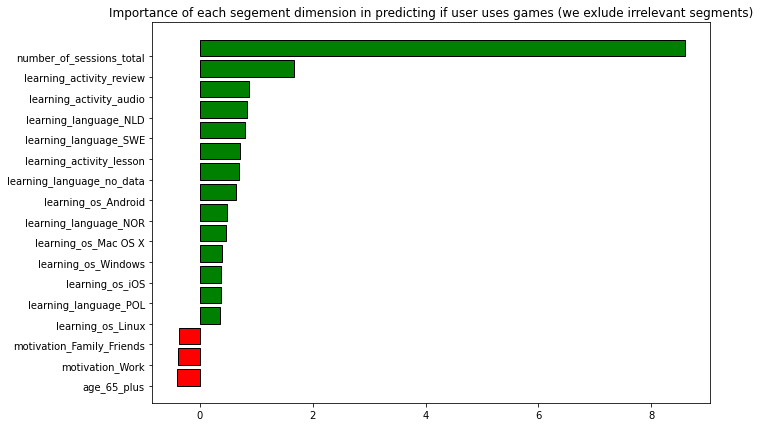

In [203]:
# barplot of features

feature_importance = pd.DataFrame({'feature_name':final.drop(columns=['learning_activity_game','uuid'])\
                                                                                .columns.tolist(),
                                    'odds':model.coef_[0]})

feature_importance=feature_importance[feature_importance.odds.apply(abs)>=0.3]\
                    .sort_values(by='odds',ascending=True)

# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
height = feature_importance.odds
bars = feature_importance.feature_name
y_pos = np.arange(len(bars))

colors = ['g' if e >= 0 else 'r' for e in height]

plt.figure(figsize=(10, 7))  # width:20, height:3

# Create bars
plt.barh(y_pos, height,color=colors,edgecolor='black', align='edge')

# Create names on the x-axis
plt.yticks(y_pos, bars)

plt.title('Importance of each segement dimension in predicting if user uses games (we exlude irrelevant segments)')
# Show graphic
plt.show()

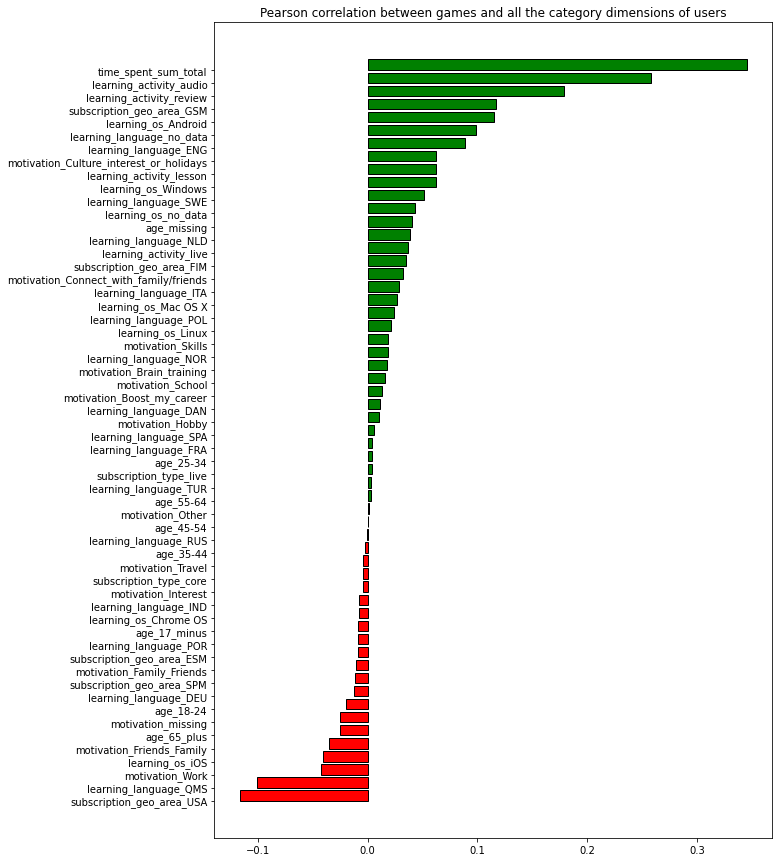

In [200]:
# just in case - correlation matrix

# barplot of features
feature_importance=pd.DataFrame(final[final.columns[1:]].corr().learning_activity_game[:-1])

feature_importance=feature_importance[feature_importance.learning_activity_game!=1]\
        .sort_values(by='learning_activity_game',ascending=True)

# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
height = feature_importance.learning_activity_game
bars = feature_importance.index
y_pos = np.arange(len(bars))

colors = ['g' if e >= 0 else 'r' for e in height]

plt.figure(figsize=(10, 15))  # width:20, height:3

# Create bars
plt.barh(y_pos, height,color=colors,edgecolor='black', align='edge')

# Create names on the x-axis
plt.yticks(y_pos, bars)

plt.title('Pearson correlation between games and all the category dimensions of users')
# Show graphic
plt.show()


In [190]:
pd.DataFrame(final[final.columns[1:]].corr().learning_activity_game[:-1])

Index(['learning_activity_game'], dtype='object')